## 机器学习模型 

#### Import 

In [2]:
import pandas as pd
import math
from scipy import stats
import time
import numpy as np
import os
import plotly.express as px
import matplotlib.pyplot as plt
import xgboost as xgb

import wandb
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn import preprocessing
import os
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import gc 
from wandb.xgboost import wandb_callback
from wandb.keras import WandbCallback

/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]

                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size

            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]


            if self.verbose > 0:
                    pass

            yield [int(i) for i in train_array], [int(i) for i in test_array]

#### Wandb Track

In [4]:
wandb.login()



wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)


True

#### COFIG

In [5]:
import datetime
class CONFIG:
    nfold = 5
    is_local = True
    local_path = '/Users/dylan/iCollections/桌面文件/Repo/Option_Pricing/Data/Output_data/option/'
    local_log_path = '/Users/dylan/iCollections/桌面文件/Repo/Option_Pricing/Code/model_nn/log'
    colab_path = '/content/'
    seed = 42
    log_dir = local_log_path + datetime.datetime.now().strftime(r"%Y%m%d-%H%M%S")

    

#### Preprocess

In [6]:
if CONFIG.is_local:
    data = pd.read_csv(os.path.join(CONFIG.local_path, '2020_whole.csv'))
    
else:
    data = pd.read_csv(os.path.join(CONFIG.colab_path, '2020_whole.csv'))


In [7]:
# 只用 SP 试试 
data_C = data[data['call_put'] == 'c']
data_P = data[data['call_put'] == 'p']

#### cv

In [8]:
def setup_cv(df, fold):
    """return a dataframe with fold index
    Use two method here, one with PurgedGroupTimeSeriesSplit(self designed GoupKFold API in scikit-learn), one with TimeSeriesSplit
    
    To avoid the problem of differents fold with high homogeneity, should use small n_splits:
    - If your purpose is performance estimation, you need models with low bias estimates (which means no systematic distortion of estimates). 
        You can achieve this by using a higher number of folds, usually between 10 and 20.
    - If your aim is parameter tuning, you need a mix of bias and variance, so it is advisable to use a medium number of folds, usually between 5 and 7.
    - If your purpose is just to apply variable selection and simplify your dataset, you need models with low variance estimates (or you will have disagreement). 
        Hence, a lower number of folds will suffice, usually between 3 and 5.
    
    To simulate the generation of time window, use large n_splits, the step can be numbers of sample(n) // n_splits
    e.g. when n_splits = n, step = n // n = 1
    
    Args:
        df (dataframe): dataframe with time window
        fold (int): fold number

    Returns:
        dataframe: dataframe with fold index
    """
    df.reset_index(drop = True, inplace = True)
    df.sort_values(by='Date', inplace = True)
    df['fold'] = -1
    if len(data.underlying.unique()) > 1:
        cv = PurgedGroupTimeSeriesSplit(n_splits=fold, group_gap=0)
        step = df.shape[0]//fold
        print(f"{'=' * 20} step : {step} {'=' * 20}")
        for index, (train_, val_) in enumerate(cv.split(df, groups=df.underlying)):
            print(f"{'=' * 20} val_{index} {'=' * 20}")
            print(val_[-50:])
            df.iloc[val_, -1] = index
    else :
        cv = TimeSeriesSplit(n_splits=fold)
        step = df.shape[0]//fold
        print(f"{'=' * 20} step : {step} {'=' * 20}")
        for index, (train_, val_) in enumerate(cv.split(df)):
            print(f"{'=' * 20} val_{index} {'=' * 20}")
            print(val_[-50:])
            df.iloc[val_, -1] = index
    return df
        

In [9]:
data_C = setup_cv(data, CONFIG.nfold)

==================== step : 420628 ====================
==================== val_0 ====================
[2101825, 2101826, 2101827, 2101828, 2101829, 2101830, 2101831, 2101832, 2101833, 2102562, 2102563, 2102564, 2102565, 2102566, 2102567, 2102568, 2102569, 2102570, 2102571, 2102572, 2102573, 2102574, 2102575, 2102576, 2102577, 2102578, 2102579, 2102580, 2102581, 2102586, 2102587, 2102588, 2102589, 2102590, 2102591, 2102592, 2102593, 2102594, 2102595, 2102596, 2102597, 2102598, 2102599, 2102600, 2102601, 2102602, 2102603, 2102604, 2102605, 2102606]
==================== val_1 ====================
[2097621, 2097622, 2097623, 2097624, 2097625, 2097626, 2097627, 2097628, 2097629, 2097630, 2097631, 2097632, 2097633, 2097634, 2097635, 2097636, 2097637, 2097638, 2097639, 2097640, 2097641, 2097642, 2097643, 2097644, 2097645, 2097646, 2097647, 2097648, 2097649, 2097650, 2097651, 2097652, 2097653, 2097654, 2097655, 2097656, 2097657, 2097658, 2097659, 2097660, 2097661, 2097662, 2097663, 2097664, 

In [10]:
data_C.fold.unique()

array([-1,  1,  2,  0,  3,  4])

In [11]:
data_C.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Date', 'underlying', 'exchange',
       'root_symbol', 'futures_symbol', 'fut_expiration_date', 'futures_close',
       'opt_expiration_date', 'strike', 'call_put', 'style', 'bid', 'ask',
       'settlement', 'volume', 'open_interest', '1M', '3M', '6M', '12M',
       'fold'],
      dtype='object')

In [12]:
# 计算每个标的的RV
def cal_rv(df):
    """return rv of each unerlying

    Args:
        df (dataframe): df with rv
    """
    df_time = df.drop_duplicates(subset=['Date'], keep='first', inplace=False)
    df_time['sigma'] = np.std(df_time.futures_close.pct_change(1))
    dict_ = df_time[['Date', 'sigma']].set_index('Date').to_dict()['sigma']
    
    df['sigma'] = df['Date'].map(dict_)
    return df


In [13]:
# features and target

data_C = data_C.groupby('underlying').apply(cal_rv)
data_C['S_K'] = data_C.strike / data_C.futures_close
data_C.Date = pd.to_datetime(data_C.Date)
data_C.opt_expiration_date = pd.to_datetime(data_C.opt_expiration_date)
data_C['days'] = (data_C.opt_expiration_date - data_C.Date).dt.days/365

features = ['S_K', 'days', 'sigma', '12M']
target = ['settlement']


In [14]:
data_C.reset_index(drop=True, inplace=True)
data_C

,Unnamed: 0.1,Unnamed: 0,Date,underlying,exchange,root_symbol,futures_symbol,fut_expiration_date,futures_close,opt_expiration_date,...,volume,open_interest,1M,3M,6M,12M,fold,sigma,S_K,days
0,1569641,1569641,2020-01-02,DA,CME,DA,DA/20F.CM,02/05/2020,17.059999,2020-02-05,...,2,413,1.50,1.51,1.53,1.44,-1,0.126342,0.937866,0.093151
1,1572300,1572300,2020-01-02,ES,CME,EW,ES/20M.CM,06/19/2020,3259.000000,2020-04-30,...,6,15,1.50,1.51,1.53,1.44,-1,0.022691,1.080086,0.326027
2,1572299,1572299,2020-01-02,ES,CME,EW,ES/20M.CM,06/19/2020,3259.000000,2020-04-30,...,7,8,1.50,1.51,1.53,1.44,-1,0.022691,1.077017,0.326027
3,1572298,1572298,2020-01-02,ES,CME,EW,ES/20M.CM,06/19/2020,3259.000000,2020-04-30,...,20,161,1.50,1.51,1.53,1.44,-1,0.022691,1.073949,0.326027
4,1572297,1572297,2020-01-02,ES,CME,EW,ES/20M.CM,06/19/2020,3259.000000,2020-04-30,...,13,7,1.50,1.51,1.53,1.44,-1,0.022691,1.070881,0.326027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2103137,1018733,1018733,2020-11-24,ES,CME,EW2,ES/20Z.CM,12/18/2020,3632.750000,2020-12-11,...,3,223,0.08,0.09,0.10,0.09,4,0.022691,0.919414,0.046575
2103138,1018734,1018734,2020-11-24,ES,CME,EW2,ES/20Z.CM,12/18/2020,3632.750000,2020-12-11,...,134,6061,0.08,0.09,0.10,0.09,4,0.022691,0.920790,0.046575
2103139,1018735,1018735,2020-11-24,ES,CME,EW2,ES/20Z.CM,12/18/2020,3632.750000,2020-12-11,...,42,420,0.08,0.09,0.10,0.09,4,0.022691,0.922166,0.046575
2103140,1018725,1018725,2020-11-24,ES,CME,EW2,ES/20Z.CM,12/18/2020,3632.750000,2020-12-11,...,39,242,0.08,0.09,0.10,0.09,4,0.022691,0.867112,0.046575


## 处理 inf

In [15]:
data_C.replace([np.inf, -np.inf], np.nan, inplace=True)

In [16]:
data_C.dropna(inplace=True)

### model

#### xgboost


In [52]:
def xgb_model(data,nfold):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': 0.01,
        'random_state': CONFIG.seed,
    }
    scores = []
    models = []
    
    for f in range(nfold):
        data.reset_index(drop=True, inplace=True)
        train_idx = data[data.fold != f].index
        val_idx = data[data.fold == f].index
        min_max_scaler = preprocessing.StandardScaler()

        train_x = min_max_scaler.fit_transform(data.iloc[train_idx, :][features])
        train_y = min_max_scaler.fit_transform(data.iloc[train_idx, :][target])
        
        val_x = min_max_scaler.fit_transform(data.iloc[val_idx, :][features])
        val_y = min_max_scaler.fit_transform(data.iloc[val_idx, :][target])
        if data.underlying.value_counts().shape[0] == 1:
            run = wandb.init(project="Option-project", entity="dylanli", reinit=True, name=f'xgb_single_{f}')
        else : 
            run = wandb.init(project="Option-project", entity="dylanli", reinit=True, name=f'xgb_multi_{f}')
        
        callback = wandb_callback()
        
        model = xgb.XGBRegressor()
        model.set_params(**params)
        model.fit(train_x, train_y, early_stopping_rounds=10, eval_set=[(val_x, val_y)], callbacks=[callback])
        model.save_model(f'/Users/dylan/iCollections/桌面文件/Repo/Option_Pricing/Code/model_xgb/model_{f}.json')
        # plot
        ax = xgb.plot_importance(model)
        plt.show(ax)
        wandb.log({"chart" : ax})

        print(f"{'='*20}{f} model trained{'='*20}")
        off_pred = model.predict(val_x, ntree_limit=model.best_ntree_limit)
        off_score = np.sqrt(mean_squared_error(val_y, off_pred))
        scores.append(off_score)
        models.append(model)
        print(f"{'=' * 20} fold_{f} {'=' * 20}")
        print(f'rmse: {off_score}')
        
        
        del train_x, train_y, val_x, val_y
        gc.collect()
        
        run.finish()
    
    return scores, models
        
        


validation_0-rmse,█▇▆▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▂▂▃▃▄▅▅▆
validation_0-rmse,142.46426


/var/folders/9l/qzgwttq17ps8lhfhrtgpdkx00000gn/T/ipykernel_78287/1921192065.py:27: UserWarning: wandb_callback will be deprecated in favor of WandbCallback. Please use WandbCallback for more features.
  callback = wandb_callback()
/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Will train until validation_0-rmse hasn't improved in 10 rounds.
0	validation_0-rmse:1.11542
1	validation_0-rmse:1.11291
2	validation_0-rmse:1.11056
3	validation_0-rmse:1.10831
4	validation_0-rmse:1.10613
5	validation_0-rmse:1.10411
6	validation_0-rmse:1.10214
7	validation_0-rmse:1.10028
8	validation_0-rmse:1.09858
9	validation_0-rmse:1.09682
10	validation_0-rmse:1.09534
11	validation_0-rmse:1.09379
12	validation_0-rmse:1.09237
13	validation_0-rmse:1.09108
14	validation_0-rmse:1.08987
15	validation_0-rmse:1.08863
16	validation_0-rmse:1.08753
17	validation_0-rmse:1.08644
18	validation_0-rmse:1.08557
19	validation_0-rmse:1.08463
20	validation_0-rmse:1.08393
21	validation_0-rmse:1.08330
22	validation_0-rmse:1.08258
23	validation_0-rmse:1.08204
24	validation_0-rmse:1.08147
25	validation_0-rmse:1.08098
26	validation_0-rmse:1.08073
27	validation_0-rmse:1.08054
28	validation_0-rmse:1.08041
29	validation_0-rmse:1.08031
30	validation_0-rmse:1.08014
31	validation_0-rmse:1.07998
32	validation_0-r

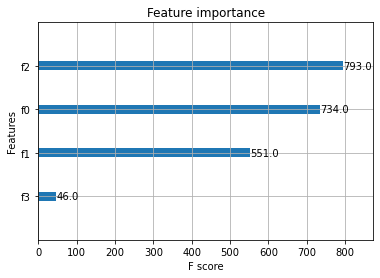

====================0 model trained====================
==================== fold_0 ====================
rmse: 1.0799835737971333


/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/site-packages/xgboost/core.py:105: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



validation_0-rmse,██▇▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
validation_0-rmse,1.08306


/var/folders/9l/qzgwttq17ps8lhfhrtgpdkx00000gn/T/ipykernel_78287/1921192065.py:27: UserWarning:

wandb_callback will be deprecated in favor of WandbCallback. Please use WandbCallback for more features.

/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



Will train until validation_0-rmse hasn't improved in 10 rounds.
0	validation_0-rmse:1.11506
1	validation_0-rmse:1.11215
2	validation_0-rmse:1.10932
3	validation_0-rmse:1.10659
4	validation_0-rmse:1.10391
5	validation_0-rmse:1.10128
6	validation_0-rmse:1.09861
7	validation_0-rmse:1.09619
8	validation_0-rmse:1.09380
9	validation_0-rmse:1.09140
10	validation_0-rmse:1.08924
11	validation_0-rmse:1.08705
12	validation_0-rmse:1.08484
13	validation_0-rmse:1.08282
14	validation_0-rmse:1.08083
15	validation_0-rmse:1.07878
16	validation_0-rmse:1.07690
17	validation_0-rmse:1.07512
18	validation_0-rmse:1.07328
19	validation_0-rmse:1.07155
20	validation_0-rmse:1.06989
21	validation_0-rmse:1.06831
22	validation_0-rmse:1.06669
23	validation_0-rmse:1.06515
24	validation_0-rmse:1.06369
25	validation_0-rmse:1.06230
26	validation_0-rmse:1.06091
27	validation_0-rmse:1.05956
28	validation_0-rmse:1.05828
29	validation_0-rmse:1.05716
30	validation_0-rmse:1.05601
31	validation_0-rmse:1.05479
32	validation_0-r

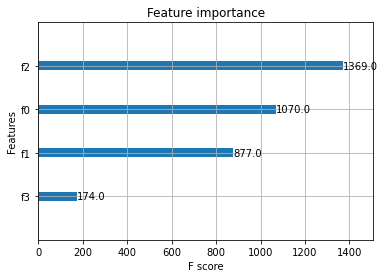

====================1 model trained====================
==================== fold_1 ====================
rmse: 1.037858707978806


/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/site-packages/xgboost/core.py:105: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



validation_0-rmse,██▇▇▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_0-rmse,1.03846


/var/folders/9l/qzgwttq17ps8lhfhrtgpdkx00000gn/T/ipykernel_78287/1921192065.py:27: UserWarning:

wandb_callback will be deprecated in favor of WandbCallback. Please use WandbCallback for more features.

/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



Will train until validation_0-rmse hasn't improved in 10 rounds.
0	validation_0-rmse:1.11478
1	validation_0-rmse:1.11159
2	validation_0-rmse:1.10848
3	validation_0-rmse:1.10543
4	validation_0-rmse:1.10245
5	validation_0-rmse:1.09954
6	validation_0-rmse:1.09676
7	validation_0-rmse:1.09398
8	validation_0-rmse:1.09133
9	validation_0-rmse:1.08867
10	validation_0-rmse:1.08620
11	validation_0-rmse:1.08379
12	validation_0-rmse:1.08143
13	validation_0-rmse:1.07912
14	validation_0-rmse:1.07688
15	validation_0-rmse:1.07469
16	validation_0-rmse:1.07255
17	validation_0-rmse:1.07047
18	validation_0-rmse:1.06844
19	validation_0-rmse:1.06646
20	validation_0-rmse:1.06453
21	validation_0-rmse:1.06264
22	validation_0-rmse:1.06081
23	validation_0-rmse:1.05902
24	validation_0-rmse:1.05727
25	validation_0-rmse:1.05549
26	validation_0-rmse:1.05384
27	validation_0-rmse:1.05225
28	validation_0-rmse:1.05068
29	validation_0-rmse:1.04917
30	validation_0-rmse:1.04770
31	validation_0-rmse:1.04625
32	validation_0-r

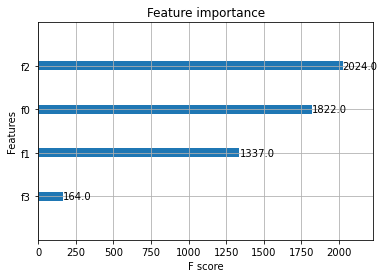

====================2 model trained====================
==================== fold_2 ====================
rmse: 1.0093050711413805


/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/site-packages/xgboost/core.py:105: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



wandb: Network error (SSLError), entering retry loop.
wandb: Network error (SSLError), entering retry loop.


validation_0-rmse,██▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_0-rmse,1.0093


/var/folders/9l/qzgwttq17ps8lhfhrtgpdkx00000gn/T/ipykernel_78287/1921192065.py:27: UserWarning:

wandb_callback will be deprecated in favor of WandbCallback. Please use WandbCallback for more features.

/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



Will train until validation_0-rmse hasn't improved in 10 rounds.
0	validation_0-rmse:1.13625
1	validation_0-rmse:1.17914
2	validation_0-rmse:1.24363
3	validation_0-rmse:1.32609
4	validation_0-rmse:1.42296
5	validation_0-rmse:1.53110
6	validation_0-rmse:1.64791
7	validation_0-rmse:1.77136
8	validation_0-rmse:1.89984
9	validation_0-rmse:2.03210
Stopping. Best iteration:
[0]	validation_0-rmse:1.13625


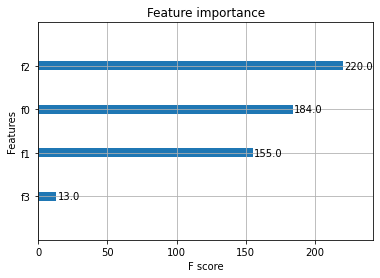

====================3 model trained====================
==================== fold_3 ====================
rmse: 1.136250795784901


/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/site-packages/xgboost/core.py:105: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



validation_0-rmse,▁▁▂▂▃▄▄▅▆▇█
validation_0-rmse,2.16719


/var/folders/9l/qzgwttq17ps8lhfhrtgpdkx00000gn/T/ipykernel_78287/1921192065.py:27: UserWarning:

wandb_callback will be deprecated in favor of WandbCallback. Please use WandbCallback for more features.

/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/site-packages/xgboost/training.py:17: UserWarning:

Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html



Will train until validation_0-rmse hasn't improved in 10 rounds.
0	validation_0-rmse:1.11776
1	validation_0-rmse:1.11782
2	validation_0-rmse:1.11819
3	validation_0-rmse:1.11888
4	validation_0-rmse:1.11986
5	validation_0-rmse:1.12113
6	validation_0-rmse:1.12264
7	validation_0-rmse:1.12451
8	validation_0-rmse:1.12647
9	validation_0-rmse:1.12885
Stopping. Best iteration:
[0]	validation_0-rmse:1.11776


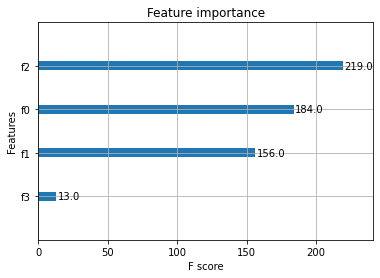

====================4 model trained====================
==================== fold_4 ====================
rmse: 1.1177624899871548


/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/site-packages/xgboost/core.py:105: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



validation_0-rmse,▁▁▁▂▂▃▄▄▆▇█
validation_0-rmse,1.13131


In [53]:
scores, models = xgb_model(data_C, CONFIG.nfold)

#### NN
NN 的设计 
- BatchNormalization
- Dense 
- dense_block(x3)

- batch_size = 128
- epochs = 100
- optimizer = Adam(0.01)


In [17]:
sweep_config = {
    'method' : 'bayes',
    'metric' : {
        'name' : 'rmse',
        'goal' : 'minimize',
    },
    'parameters' : {
        'epochs': {
            'values' : [50, 100 ,200]
        },
        'dropout' : {
            'values': [0.8, 0.6 , 0.5, 0.4]
        },
        'learning_rate' : {
            'values': [0.01, 0.001, 0.003, 0.1]
        },
        'optimizer' : {
            'values' : ['adam',  'sgd']
        },
        'activation' : {
            'values' : ['relu', 'swish']
        },
        'nn_nodes': {
            'values' : [[512,256],[256,128,64],[256,128,64],[256,64,16],[128,32], []]
        }
    },
    'early_terminate' : {
        'type' : 'hyperband',
        'max_iter' : 10,
        's' : 3
    }
}


In [24]:
# Initialize a new sweep
# Arguments:
#     – sweep_config: the sweep config dictionary defined above
#     – entity: Set the username for the sweep
#     – project: Set the project name for the sweep
sweep_id = wandb.sweep(sweep_config, entity="dylanli", project="Option-project")

Create sweep with ID: qoq1008c
Sweep URL: https://wandb.ai/dylanli/Option-project/sweeps/qoq1008c


In [25]:

def nn_model(data=data_C, nfold=CONFIG.nfold,log=CONFIG.log_dir, is_sweep=True):
    
    config_defaults = {
    'batch_size': 1024,
    'epochs': 100,
    'dropout': 0.5,
    'activation_type': 'swish',
    'optimizer': 'adam',
    'seed': 42,
    'learning_rate': 1e-3,
    'nn_nodes' : [128, 128, 128],
    }

    if data.underlying.value_counts().shape[0] == 1:
        run = wandb.init(config=config_defaults, project="Option-project", entity="dylanli", reinit=True, name=f'nn_single')
    else : 
        run = wandb.init(config=config_defaults, project="Option-project", entity="dylanli", reinit=True, name=f'nn_multi')
    
    
    config = wandb.config
    
    # Deine the optimizer
    if config.optimizer=='sgd':
        optimizer = keras.optimizers.SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=0.9, nesterov=True)
    elif config.optimizer=='adam':
        optimizer = keras.optimizers.Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
        
    def dense_block(x, n_nodes, p=0.5, activation='swish'):
        x = layers.Dropout(p)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(n_nodes, activation=activation)(x)
        return x
    
    def get_nn(dense_blocks, optimizer, dropout):
        input_ = layers.Input(shape=(len(features),))
        x = layers.BatchNormalization()(input_)
        x = layers.Dense(256, activation='swish')(x)
        
        #TODO 多层连接
        if len(dense_blocks) >= 1:
            p = dropout
            for units in dense_blocks:
                x = dense_block(x, units, p)
                p -= 0.05
            
        output = layers.Dense(1)(x)
        
        model = keras.Model(input_, output)
            
        model.compile(optimizer, loss=tf.keras.losses.MeanAbsoluteError(name='val_loss'), metrics=[tf.keras.losses.MeanAbsoluteError(name='val_loss')])
        
        return model
    
    models = []
    scores = []
    for f in range(nfold):
        data.reset_index(drop=True, inplace=True)
        
        train_idx = data[data.fold != f].index
        val_idx = data[data.fold == f].index
        scaler = preprocessing.StandardScaler()
        
        train_x = scaler.fit_transform(data.loc[train_idx, features])
        train_y = scaler.fit_transform(np.array(data.loc[train_idx, ['settlement']]))
        
        val_x = scaler.fit_transform(data.loc[val_idx, features])
        val_y = scaler.fit_transform(np.array(data.loc[val_idx, ['settlement']]))
        
        
        checkpoint = keras.callbacks.ModelCheckpoint(filepath=f'/Users/dylan/DylanLi/XJTLU/期权项目/Code/model_nn/model_nn_{f}.hdf5', save_best_only=True)
        early_stop = keras.callbacks.EarlyStopping(patience=config.epochs//4)
        tesnsorboard = keras.callbacks.TensorBoard(log, histogram_freq=1)
        model = get_nn(config.nn_nodes, optimizer, config.dropout)
        print(f"{'=' * 20} fold_{f} Training {'=' * 20}")
        history = model.fit(train_x, train_y, epochs=config.epochs, batch_size=config.batch_size, validation_data=(val_x, val_y), callbacks=[checkpoint, early_stop, WandbCallback()], validation_freq=[1,1,1])
        
        pd.DataFrame(history.history, columns=['loss', 'val_loss']).plot()
        plt.title("MSE")
        plt.show()
        #loss, mae, mse = model.evaluate(val_x, val_y)
        #print(f"evaluation: loss: {loss}, mae: {mae}, mse: {mse}")
        
        model.load_weights(f'/Users/dylan/DylanLi/XJTLU/期权项目/Code/model_nn/model_nn_{f}.hdf5')
        off_pred = model.predict(val_x)
        off_score = np.sqrt(mean_squared_error(val_y, off_pred))
        #off_score = 0
        
        scores.append(off_score)
        print(f"{'=' * 20} fold_{f} score {'=' * 20}")
        print(f"rmse: {off_score}")
        
        del train_x, train_y, val_x, val_y
        gc.collect()
        
        run.finish()
        break
        
    #wandb.log({"Fold scores": scores})
    #return scores, models
        

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: gz538n93 with config:
wandb: 	activation: swish
wandb: 	dropout: 0.8
wandb: 	epochs: 200
wandb: 	learning_rate: 0.1
wandb: 	nn_nodes: []
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.
wandb: Network error (ReadTimeout), entering retry loop.


==================== fold_0 Training ====================
Epoch 1/200


2022-05-23 15:31:04.160451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1850/1850 [==============================] - ETA: 0s - loss: 0.2750 - val_loss: 0.2750

2022-05-23 15:31:17.207367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1850/1850 [==============================] - 14s 7ms/step - loss: 0.2750 - val_loss: 0.2900 - val_val_loss: 0.2900 - _timestamp: 1653291078.0000 - _runtime: 28.0000
Epoch 2/200
1850/1850 [==============================] - 12s 6ms/step - loss: 0.2740 - val_loss: 0.2740 - _timestamp: 1653291090.0000 - _runtime: 40.0000
Epoch 3/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2738 - val_loss: 0.2738 - _timestamp: 1653291100.0000 - _runtime: 50.0000
Epoch 4/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2739 - val_loss: 0.2739 - _timestamp: 1653291111.0000 - _runtime: 61.0000
Epoch 5/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2690 - val_loss: 0.2690 - _timestamp: 1653291122.0000 - _runtime: 72.0000
Epoch 6/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2634 - val_loss: 0.2634 - _timestamp: 1653291132.0000 - _runtime: 82.0000
Epoch 7/200
1850/1850 [==============================] - 11s 6ms/

wandb: Network error (TransientError), entering retry loop.


1850/1850 [==============================] - 11s 6ms/step - loss: 0.2568 - val_loss: 0.2568 - _timestamp: 1653291251.0000 - _runtime: 201.0000
Epoch 18/200
1565/1850 [========================>.....] - ETA: 1s - loss: 0.2564 - val_loss: 0.2564

Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 170, in check_status
    status_response = self._interface.communicate_stop_status()
  File "/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/site-packages/wandb/sdk/interface/interface.py", line 114, in communicate_stop_status
    resp = self._communicate_stop_status(status)
  File "/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/site-packages/wandb/sdk/interface/interface_shared.py", line 395, in _communicate_stop_status
    resp = self._communicate(req, local=True)
  File "/Users/dylan/miniforge3/envs/machine_learni

1575/1850 [========================>.....] - ETA: 1s - loss: 0.2563 - val_loss: 0.2563

Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/site-packages/wandb/sdk/wandb_run.py", line 152, in check_network_status
    status_response = self._interface.communicate_network_status()
  File "/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/site-packages/wandb/sdk/interface/interface.py", line 125, in communicate_network_status
    resp = self._communicate_network_status(status)
  File "/Users/dylan/miniforge3/envs/machine_learning/lib/python3.8/site-packages/wandb/sdk/interface/interface_shared.py", line 405, in _communicate_network_status
    resp = self._communicate(req, local=True)
  File "/Users/dylan/miniforge3

1850/1850 [==============================] - 11s 6ms/step - loss: 0.2565 - val_loss: 0.2565 - _timestamp: 1653291261.0000 - _runtime: 211.0000
Epoch 19/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2563 - val_loss: 0.2563 - _timestamp: 1653291272.0000 - _runtime: 222.0000
Epoch 20/200
1850/1850 [==============================] - 10s 6ms/step - loss: 0.2564 - val_loss: 0.2564 - _timestamp: 1653291282.0000 - _runtime: 232.0000
Epoch 21/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2560 - val_loss: 0.2560 - _timestamp: 1653291293.0000 - _runtime: 243.0000
Epoch 22/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2558 - val_loss: 0.2558 - _timestamp: 1653291304.0000 - _runtime: 254.0000
Epoch 23/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2557 - val_loss: 0.2557 - _timestamp: 1653291314.0000 - _runtime: 264.0000
Epoch 24/200
1850/1850 [==============================] - 11s 6ms/step - loss

wandb: Network error (SSLError), entering retry loop.


1850/1850 [==============================] - 11s 6ms/step - loss: 0.2554 - val_loss: 0.2554 - _timestamp: 1653291336.0000 - _runtime: 286.0000
Epoch 26/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2553 - val_loss: 0.2553 - _timestamp: 1653291346.0000 - _runtime: 296.0000
Epoch 27/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2552 - val_loss: 0.2552 - _timestamp: 1653291357.0000 - _runtime: 307.0000
Epoch 28/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2551 - val_loss: 0.2551 - _timestamp: 1653291368.0000 - _runtime: 318.0000
Epoch 29/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2553 - val_loss: 0.2553 - _timestamp: 1653291378.0000 - _runtime: 328.0000
Epoch 30/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2550 - val_loss: 0.2550 - _timestamp: 1653291389.0000 - _runtime: 339.0000
Epoch 31/200
1850/1850 [==============================] - 11s 6ms/step - loss

wandb: Network error (ProxyError), entering retry loop.


1850/1850 [==============================] - 11s 6ms/step - loss: 0.2515 - val_loss: 0.2515 - _timestamp: 1653291909.0000 - _runtime: 859.0000
Epoch 80/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2516 - val_loss: 0.2516 - _timestamp: 1653291920.0000 - _runtime: 870.0000
Epoch 81/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2516 - val_loss: 0.2516 - _timestamp: 1653291930.0000 - _runtime: 880.0000
Epoch 82/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2516 - val_loss: 0.2516 - _timestamp: 1653291941.0000 - _runtime: 891.0000
Epoch 83/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2513 - val_loss: 0.2513 - _timestamp: 1653291952.0000 - _runtime: 902.0000
Epoch 84/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2515 - val_loss: 0.2515 - _timestamp: 1653291962.0000 - _runtime: 912.0000
Epoch 85/200
1850/1850 [==============================] - 11s 6ms/step - loss

wandb: Network error (SSLError), entering retry loop.


1850/1850 [==============================] - 11s 6ms/step - loss: 0.2510 - val_loss: 0.2510 - _timestamp: 1653292036.0000 - _runtime: 986.0000
Epoch 92/200
1850/1850 [==============================] - 10s 6ms/step - loss: 0.2511 - val_loss: 0.2511 - _timestamp: 1653292047.0000 - _runtime: 997.0000
Epoch 93/200
1850/1850 [==============================] - 10s 6ms/step - loss: 0.2511 - val_loss: 0.2511 - _timestamp: 1653292057.0000 - _runtime: 1007.0000
Epoch 94/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2509 - val_loss: 0.2509 - _timestamp: 1653292068.0000 - _runtime: 1018.0000
Epoch 95/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2508 - val_loss: 0.2508 - _timestamp: 1653292078.0000 - _runtime: 1028.0000
Epoch 96/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2509 - val_loss: 0.2509 - _timestamp: 1653292089.0000 - _runtime: 1039.0000
Epoch 97/200
1850/1850 [==============================] - 11s 6ms/step - 

wandb: Network error (ProxyError), entering retry loop.


1850/1850 [==============================] - 11s 6ms/step - loss: 0.2489 - val_loss: 0.2489 - _timestamp: 1653293008.0000 - _runtime: 1958.0000
Epoch 183/200
1850/1850 [==============================] - 10s 6ms/step - loss: 0.2488 - val_loss: 0.2488 - _timestamp: 1653293018.0000 - _runtime: 1968.0000
Epoch 184/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2489 - val_loss: 0.2489 - _timestamp: 1653293029.0000 - _runtime: 1979.0000
Epoch 185/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2490 - val_loss: 0.2490 - _timestamp: 1653293039.0000 - _runtime: 1989.0000
Epoch 186/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2487 - val_loss: 0.2487 - _timestamp: 1653293050.0000 - _runtime: 2000.0000
Epoch 187/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2488 - val_loss: 0.2488 - _timestamp: 1653293061.0000 - _runtime: 2011.0000
Epoch 188/200
1850/1850 [==============================] - 11s 6ms

wandb: Network error (ProxyError), entering retry loop.


1850/1850 [==============================] - 11s 6ms/step - loss: 0.2484 - val_loss: 0.2484 - _timestamp: 1653293177.0000 - _runtime: 2127.0000
Epoch 199/200
1850/1850 [==============================] - 11s 6ms/step - loss: 0.2485 - val_loss: 0.2485 - _timestamp: 1653293188.0000 - _runtime: 2138.0000
Epoch 200/200
1850/1850 [==============================] - 10s 6ms/step - loss: 0.2485 - val_loss: 0.2485 - _timestamp: 1653293198.0000 - _runtime: 2148.0000


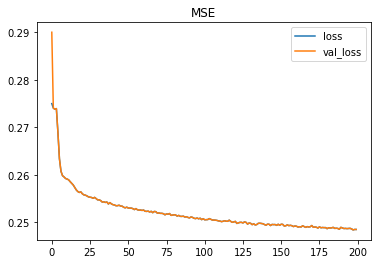

2022-05-23 16:06:39.010474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


==================== fold_0 score ====================
rmse: 1.0124367721760243


wandb: Network error (SSLError), entering retry loop.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_val_loss,▁
best_epoch,197
best_val_loss,0.24843
epoch,199
loss,0.24852
val_loss,0.24852
val_val_loss,0.29003


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aq9eawdy with config:
wandb: 	activation: relu
wandb: 	dropout: 0.6
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	nn_nodes: [512, 256]
wandb: 	optimizer: sgd
wandb: Currently logged in as: dylanli (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


==================== fold_0 Training ====================
Epoch 1/200


2022-05-23 16:08:13.492064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1850/1850 [==============================] - ETA: 0s - loss: 0.3198 - val_loss: 0.3198

2022-05-23 16:08:36.183925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1850/1850 [==============================] - 25s 12ms/step - loss: 0.3198 - val_loss: 0.2890 - val_val_loss: 0.2890 - _timestamp: 1653293317.0000 - _runtime: 35.0000
Epoch 2/200
1850/1850 [==============================] - 22s 12ms/step - loss: 0.2727 - val_loss: 0.2727 - _timestamp: 1653293339.0000 - _runtime: 57.0000
Epoch 3/200
1850/1850 [==============================] - 21s 11ms/step - loss: 0.2726 - val_loss: 0.2726 - _timestamp: 1653293360.0000 - _runtime: 78.0000
Epoch 4/200
1850/1850 [==============================] - 21s 11ms/step - loss: 0.2725 - val_loss: 0.2725 - _timestamp: 1653293381.0000 - _runtime: 99.0000
Epoch 5/200
1850/1850 [==============================] - 22s 12ms/step - loss: 0.2721 - val_loss: 0.2721 - _timestamp: 1653293403.0000 - _runtime: 121.0000
Epoch 6/200
1850/1850 [==============================] - 21s 12ms/step - loss: 0.2716 - val_loss: 0.2716 - _timestamp: 1653293424.0000 - _runtime: 142.0000
Epoch 7/200
1850/1850 [==============================] - 

wandb: Network error (SSLError), entering retry loop.


1850/1850 [==============================] - 20s 11ms/step - loss: 0.2509 - val_loss: 0.2509 - _timestamp: 1653294994.0000 - _runtime: 1712.0000
Epoch 82/200
1850/1850 [==============================] - 20s 11ms/step - loss: 0.2507 - val_loss: 0.2507 - _timestamp: 1653295014.0000 - _runtime: 1732.0000
Epoch 83/200
1850/1850 [==============================] - 20s 11ms/step - loss: 0.2506 - val_loss: 0.2506 - _timestamp: 1653295034.0000 - _runtime: 1752.0000
Epoch 84/200
1850/1850 [==============================] - 20s 11ms/step - loss: 0.2505 - val_loss: 0.2505 - _timestamp: 1653295054.0000 - _runtime: 1772.0000
Epoch 85/200
1850/1850 [==============================] - 20s 11ms/step - loss: 0.2505 - val_loss: 0.2505 - _timestamp: 1653295074.0000 - _runtime: 1792.0000
Epoch 86/200
1850/1850 [==============================] - 22s 12ms/step - loss: 0.2504 - val_loss: 0.2504 - _timestamp: 1653295096.0000 - _runtime: 1814.0000
Epoch 87/200
1850/1850 [==============================] - 20s 11m

wandb: Ctrl + C detected. Stopping sweep.


Error in callback <function _WandbInit._pause_backend at 0x285112820> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [26]:
wandb.agent(sweep_id, function=nn_model)

### Login to tensorboard

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/fit